In [6]:
import pandas as pd
import numpy as np

def process_file(file_path, currency):
    df = pd.read_csv(file_path)
    
    # convert date columns to dd-mm-yyyy format
    df['Date'] = pd.to_datetime(df['Date']).dt.strftime('%d-%m-%Y')
    df.set_index('Date', inplace=True)
    
    # columns to be kept
    columns_to_keep = ['Close']

    # converts numbers to floating point and removes commas
    for col in columns_to_keep:
        df[col] = df[col].replace(',', '', regex=True).astype(float)
    
    # add the currency as a suffix to the retained columns
    df = df[columns_to_keep]
    df.columns = [f"{col}_{currency}" for col in columns_to_keep]
    
    return df

file_paths = {
    'ETH-EUR.csv': 'ETH',
    'BTC-EUR.csv': 'BTC',
    'DOGE-EUR.csv': 'DOGE',
    'USDT-EUR.csv': 'USDT',
    'XRP-EUR.csv': 'XRP'
}

# place the adjusted data in the dictionary
dataframes = {}
for file, code in file_paths.items():
    df_processed = process_file(file, code)
    dataframes[code] = df_processed

# merge all data frames
combined_df = pd.concat(dataframes.values(), axis=1)

# define a function that cleans the data
def clean_data(df):
    
    # check for NaN and infinity values
    if df.isna().any().any() or np.isinf(df).any().any():
        
        # handle NaN values 
        df = df.ffill().bfill()
        
        # handle infinity values
        df.replace([np.inf, -np.inf], np.nan, inplace=True)

    return df

df_clean = clean_data(combined_df)
print(df_clean.head())

            Close_ETH  Close_BTC  Close_DOGE  Close_USDT  Close_XRP
Date                                                               
04-12-2023    2061.30    39728.0    0.082351      0.9225     0.5759
03-12-2023    2007.32    37994.0    0.078228      0.9191     0.5726
02-12-2023    1992.83    37965.0    0.079103      0.9193     0.5718
01-12-2023    1922.37    37353.0    0.076899      0.9194     0.5629
30-11-2023    1880.00    36662.0    0.076479      0.9190     0.5578


In [13]:
## Test 1 Pearson Correlation Coefficient

"""
Hypothesis 1 (Correlation Among Cryptocurrencies):

Null Hypothesis (H0): There is no significant correlation 
between the market values of Ethereum and other cryptocurrencies.

Alternative Hypothesis (H1): Market values of Ethereum exhibit a significant correlation 
with other cryptocurrencies.
"""

from scipy.stats import pearsonr

# initialise two dictionaries to store coefficients and p-values
correlations = {}
p_values = {}

for column in df_clean.columns:
    
    # exclude the ETH column
    if column != 'Close_ETH':  
        corr, p_value = pearsonr(df_clean['Close_ETH'], df_clean[column])
        
        correlations[column.replace('Close_', '')] = corr
        p_values[column.replace('Close_', '')] = p_value

        # check if the p-value is less than 0.05
        if p_value < 0.05:
            print(f"ETH has a significant correlation with {column.replace('Close_', '')}: Pearson Correlation Coefficient = {corr:.4f}, p-value = {p_value:.4f}")
        else:
            print(f"ETH does not have a significant correlation with {column.replace('Close_', '')}: Pearson Correlation Coefficient = {corr:.4f}, p-value = {p_value:.4f}")

ETH has a significant correlation with BTC: Pearson Correlation Coefficient = 0.9078, p-value = 0.0000
ETH has a significant correlation with DOGE: Pearson Correlation Coefficient = -0.1115, p-value = 0.0330
ETH has a significant correlation with USDT: Pearson Correlation Coefficient = -0.5197, p-value = 0.0000
ETH has a significant correlation with XRP: Pearson Correlation Coefficient = 0.6547, p-value = 0.0000


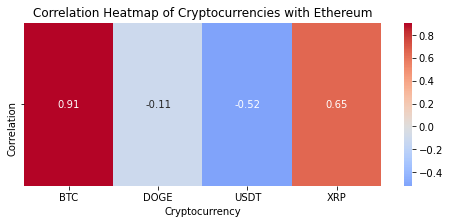

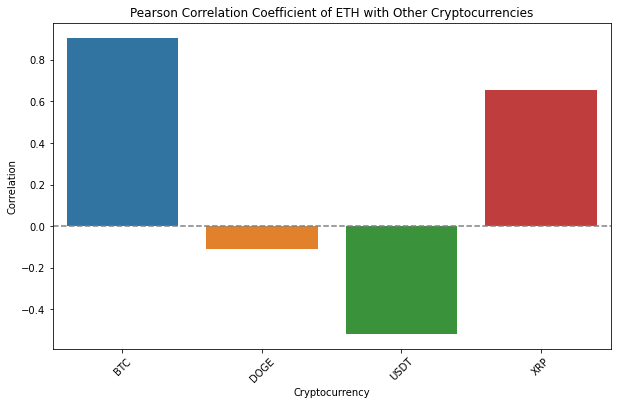

,Correlation,P-value
Cryptocurrency,,
BTC,0.9078,0.0000
DOGE,-0.1115,0.0330
USDT,-0.5197,0.0000
XRP,0.6547,0.0000


In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a DataFrame from the correlations dictionary
corr_df = pd.DataFrame(list(correlations.items()), columns=['Cryptocurrency', 'Correlation'])

corr_df.set_index('Cryptocurrency', inplace=True)

# creating heatmap-like visualization
plt.figure(figsize=(8, 3))
sns.heatmap(corr_df.T, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap of Cryptocurrencies with Ethereum')
plt.show()

# Create a bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=corr_df.index, y=corr_df['Correlation'])
plt.title('Pearson Correlation Coefficient of ETH with Other Cryptocurrencies')
plt.axhline(0, color='grey', linestyle='--')
plt.xticks(rotation=45)  # Rotate the x labels if they overlap
plt.show()

#Correlation Matrix with P-values

import pandas as pd

# Correlation Matrix with P-values
combined_df.style.format({'Correlation': '{:.4f}', 'P-value': '{:.4f}'})


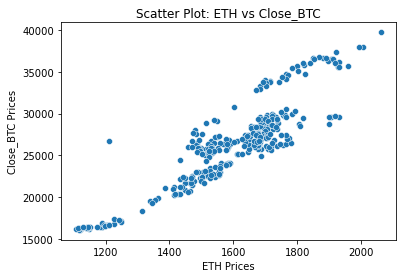

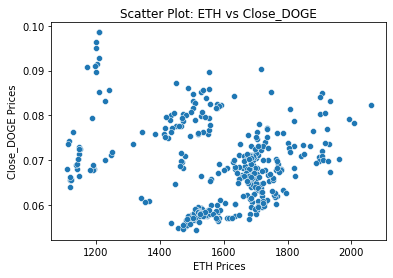

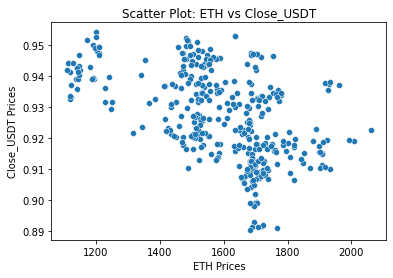

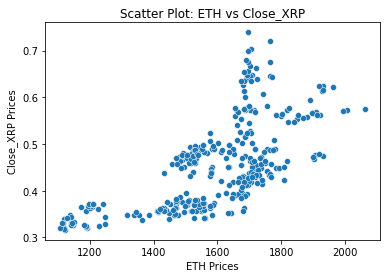

In [8]:

"""
To ensure that the underlying assumptions for using Pearson correlation hold for our dataset,
we need to verify a few key aspects:

1) Linearity: The Pearson correlation coefficient measures the degree of a linear relationship 
between two variables.

2) Bivariate Normal Distribution: Both variables should ideally be normally distributed, 
however, it's more important that their joint distribution forms a bell-shaped pattern.

3) Homoscedasticity: The variance within each variable should be consistent, 
meaning the scatter of data points should be the same across all values.

4) Independence: Each pair of observations should be independent, a challenging factor in time series 
data due to autocorrelation.

5) No Outliers: Outliers can skew the Pearson correlation, so it's important to detect and handle them 
appropriately.

But we need to note that while these assumptions are ideal, slight violations may not drastically 
impact our results

"""

#1) Linearity check:
import matplotlib.pyplot as plt
import seaborn as sns


for column in df_clean.columns:
    if column != 'Close_ETH':
        sns.scatterplot(x=df_clean['Close_ETH'], y=df_clean[column])
        plt.title(f'Scatter Plot: ETH vs {column}')
        plt.xlabel('ETH Prices')
        plt.ylabel(f'{column} Prices')
        plt.show()


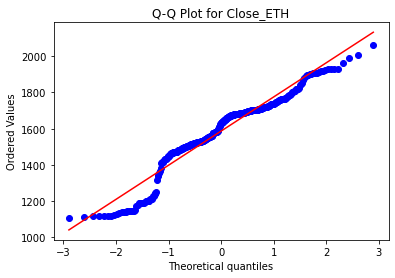

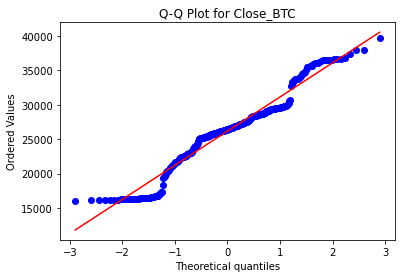

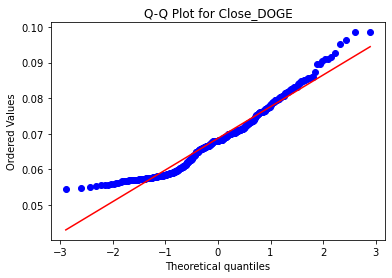

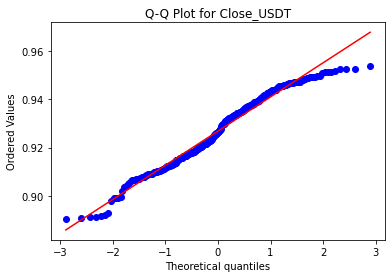

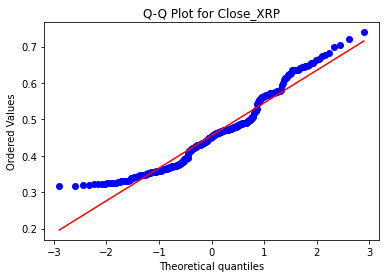

In [9]:
#2) Normality check: 
import scipy.stats as stats

# Q-Q plots for each cryptocurrency, including Ethereum
for column in df_clean.columns:
    stats.probplot(df_clean[column], dist="norm", plot=plt)
    plt.title(f'Q-Q Plot for {column}')
    plt.show()


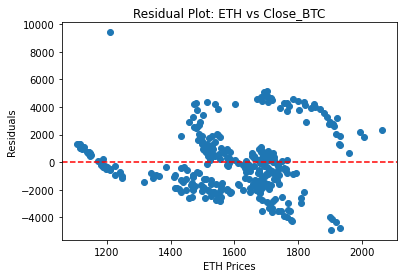

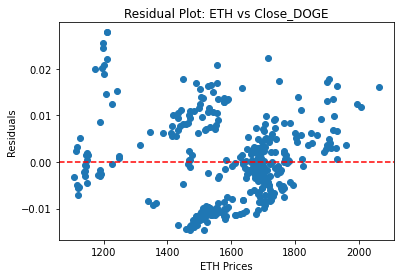

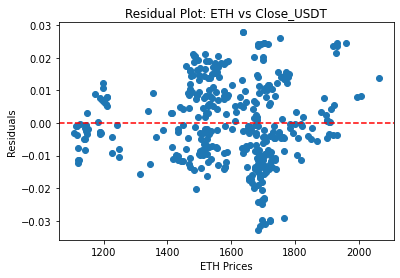

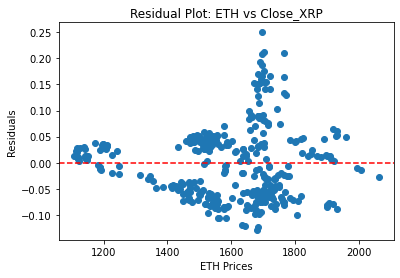

In [10]:
#3) Homoscedasticity check: 
from sklearn.linear_model import LinearRegression
import numpy as np

lr = LinearRegression()

# For each cryptocurrency
for column in df_clean.columns:
    if column != 'Close_ETH':
        X = df_clean['Close_ETH'].values.reshape(-1, 1)
        y = df_clean[column].values
        lr.fit(X, y)
        predictions = lr.predict(X)
        residuals = y - predictions

        plt.scatter(df_clean['Close_ETH'], residuals)
        plt.title(f'Residual Plot: ETH vs {column}')
        plt.xlabel('ETH Prices')
        plt.ylabel('Residuals')
        plt.axhline(y=0, color='r', linestyle='--')
        plt.show()


In [ ]:
#4) Independence check: 
#for a time series indpendence is complexed to assess need to consider autocorrelation
#therefore here we just assume this assumption has been met 

/Users/mijitrenkel/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


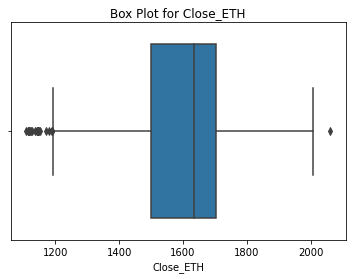

/Users/mijitrenkel/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


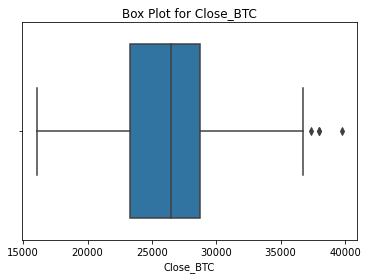

/Users/mijitrenkel/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


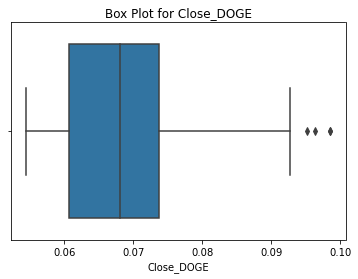

/Users/mijitrenkel/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


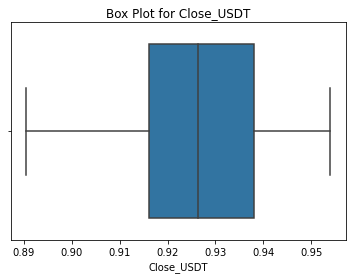

/Users/mijitrenkel/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


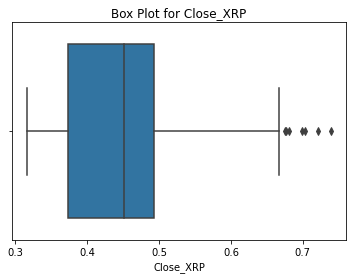

In [11]:
#5) Outliers check:
# Box plots for each cryptocurrency
for column in df_clean.columns:
    sns.boxplot(df_clean[column])
    plt.title(f'Box Plot for {column}')
    plt.show()


In [89]:
## Spearman's Rank Correlation Coefficient
"""
Non-linearity
Hypothesis 1 (Correlation Among Cryptocurrencies):

Null Hypothesis (H0): There is no significant correlation 
between the market values of Ethereum and other cryptocurrencies.

Alternative Hypothesis (H1): Market values of Ethereum exhibit a significant correlation 
with other cryptocurrencies.
"""

from scipy.stats import spearmanr

# initialise two dictionaries to store coefficients and p-values
correlations = {}
p_values = {}

for column in df_clean.columns:
    
    # exclude the ETH column
    if column != 'Close_ETH':  
        corr, p_value = spearmanr(df_clean['Close_ETH'], df_clean[column])
        
        correlations[column.replace('Close_', '')] = corr
        p_values[column.replace('Close_', '')] = p_value

        # check if the p-value is less than 0.05
        if p_value < 0.05:
            print(f"ETH has a significant correlation with {column.replace('Close_', '')}: Spearman Correlation Coefficient = {corr:.4f}, p-value = {p_value:.4f}")
        else:
            print(f"ETH does not have a significant correlation with {column.replace('Close_', '')}: Spearman Correlation Coefficient = {corr:.4f}, p-value = {p_value:.4f}")

ETH has a significant correlation with BTC: Spearman Correlation Coefficient = 0.9521, p-value = 0.0000
ETH has a significant correlation with DOGE: Spearman Correlation Coefficient = 0.8503, p-value = 0.0000
ETH has a significant correlation with USDT: Spearman Correlation Coefficient = -0.7457, p-value = 0.0000
ETH has a significant correlation with XRP: Spearman Correlation Coefficient = 0.8445, p-value = 0.0000


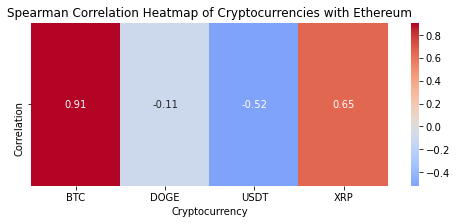

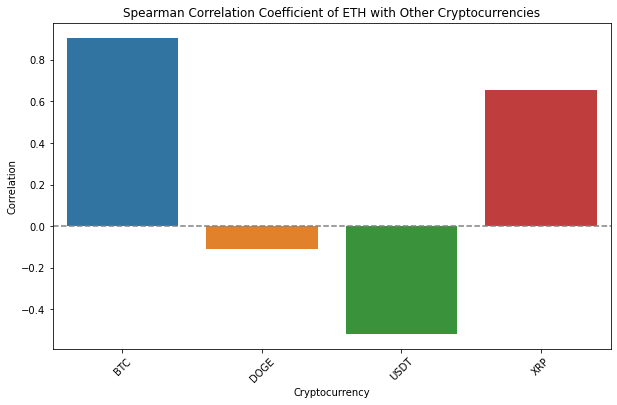

,Correlation,P-value
Cryptocurrency,,
BTC,0.9078,0.0000
DOGE,-0.1115,0.0330
USDT,-0.5197,0.0000
XRP,0.6547,0.0000


In [27]:
import pandas as pd

# Create DataFrames from the dictionaries
spearman_corr_df = pd.DataFrame(list(correlations.items()), columns=['Cryptocurrency', 'Correlation'])
spearman_p_values_df = pd.DataFrame(list(p_values.items()), columns=['Cryptocurrency', 'P-value'])

# Merge the DataFrames
spearman_combined_df = pd.merge(spearman_corr_df, spearman_p_values_df, on='Cryptocurrency')
import seaborn as sns
import matplotlib.pyplot as plt

# Create a heatmap-like visualization for the correlation values
spearman_combined_df.set_index('Cryptocurrency', inplace=True)
plt.figure(figsize=(8, 3))
sns.heatmap(spearman_combined_df[['Correlation']].T, annot=True, cmap='coolwarm', center=0)
plt.title('Spearman Correlation Heatmap of Cryptocurrencies with Ethereum')
plt.show()

# Create a bar chart for the correlation values
plt.figure(figsize=(10, 6))
sns.barplot(x=spearman_combined_df.index, y=spearman_combined_df['Correlation'])
plt.title('Spearman Correlation Coefficient of ETH with Other Cryptocurrencies')
plt.axhline(0, color='grey', linestyle='--')
plt.xticks(rotation=45)  # Rotate x labels if they overlap
plt.show()

# Display the DataFrame with formatted numbers
spearman_combined_df.style.format({'Correlation': '{:.4f}', 'P-value': '{:.4f}'})


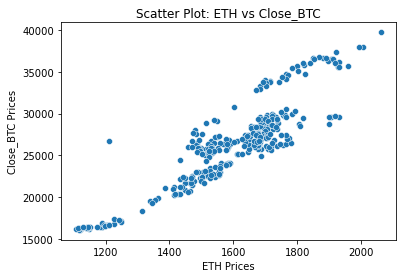

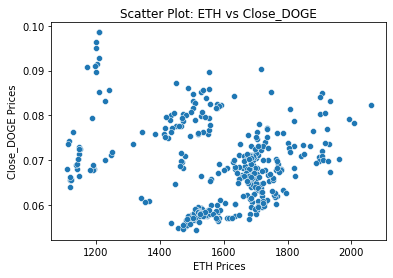

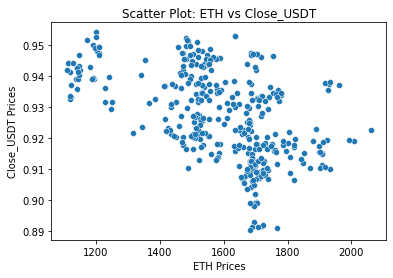

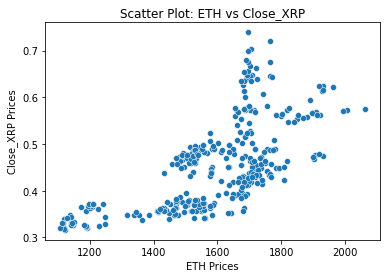

In [23]:

"""
To ensure that the underlying assumptions for using Spearman's rank correlation coefficient correlation hold 
for our dataset, we need to verify a few key aspects:

1) Monotonic Relationship: The Spearman correlation measures the strength and direction of a monotonic 
relationship between two variables. A monotonic relationship either consistently increases or decreases 
as one variable increases.

2)Ordinal Data: Spearman correlation is most suitable for ordinal data, where data can be ranked but not 
necessarily measured, but it can also be applied to interval and ratio data.

3)No Repeated Data Values: The Spearman correlation is most effective when there are few tied ranks in the data. 
Tied ranks occur when the same value appears multiple times. While it can handle ties, many can affect the 
correlation strength.

But we need to note that while these assumptions are ideal, slight violations may not drastically 
impact our results

"""
# Montonic Relationship

        
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'Close_ETH' is your Ethereum data and 'column' is the other cryptocurrency
for column in df_clean.columns:
    if column != 'Close_ETH':
        sns.scatterplot(x=df_clean['Close_ETH'], y=df_clean[column])
        plt.title(f'Scatter Plot: ETH vs {column}')
        plt.xlabel('ETH Prices')
        plt.ylabel(f'{column} Prices')
        plt.show()


In [25]:
#3)Uniqueness 

# Check for repeated values in Ethereum prices
unique_eth = df_clean['Close_ETH'].nunique()
total_eth = df_clean['Close_ETH'].count()
print(f"Unique ETH Prices: {unique_eth}, Total ETH Prices: {total_eth}")

# Check for other cryptocurrencies
for column in df_clean.columns:
    if column != 'Close_ETH':
        unique_crypto = df_clean[column].nunique()
        total_crypto = df_clean[column].count()
        print(f"Unique prices for {column.replace('Close_', '')}: {unique_crypto}, Total prices: {total_crypto}")


Unique ETH Prices: 364, Total ETH Prices: 366
Unique prices for BTC: 360, Total prices: 366
Unique prices for DOGE: 359, Total prices: 366
Unique prices for USDT: 262, Total prices: 366
Unique prices for XRP: 333, Total prices: 366


In [39]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller

# Define the preprocessing functions
def process_file(file_path, currency):
    df = pd.read_csv(file_path)
    df['Date'] = pd.to_datetime(df['Date']).dt.strftime('%d-%m-%Y')
    df.set_index('Date', inplace=True)
    columns_to_keep = ['Close']
    for col in columns_to_keep:
        df[col] = df[col].replace(',', '', regex=True).astype(float)
    df = df[columns_to_keep]
    df.columns = [f"{col}_{currency}" for col in columns_to_keep]
    return df

def clean_data(df):
    if df.isna().any().any() or np.isinf(df).any().any():
        df = df.ffill().bfill()
        df.replace([np.inf, -np.inf], np.nan, inplace=True)
    return df

# Load and process each dataset
file_paths = {
    'ETH-EUR.csv': 'ETH',
    'BTC-EUR.csv': 'BTC',
    'DOGE-EUR.csv': 'DOGE',
    'USDT-EUR.csv': 'USDT',
    'XRP-EUR.csv': 'XRP',
    'S&P.csv': 'SP',
    'Gold.csv': 'Gold',
    'Apple.csv': 'Apple',
    'Nasdaq.csv': 'Nasdaq',
    'Silver.csv': 'Silver',
    'Oil.csv': 'Oil',
    'ADA-EUR.csv': 'ADE'
}

dataframes = {code: process_file(file, code) for file, code in file_paths.items()}

# Merge all dataframes
combined_df_extended = pd.concat(dataframes.values(), axis=1, join='inner')

# Clean the merged dataframe
df_clean_extended = clean_data(combined_df_extended)

# Now perform the ADF test on the cleaned extended data
columns = df_clean_extended.columns
df_clean_stationary_extended = pd.DataFrame(index=df_clean_extended.index)

for column in columns:
    # Original series ADF test
    adf_result_original = adfuller(df_clean_extended[column].dropna())
    print(f"ADF Test Results for Original {column}:")
    print('ADF Statistic: %f' % adf_result_original[0])
    print('p-value: %f' % adf_result_original[1])

    if adf_result_original[1] < 0.05:
        print(f"The original time series of {column} is stationary.\n")
        df_clean_stationary_extended[column] = df_clean_extended[column]
    else:
        print(f"The original time series of {column} is not stationary.\n")
        diff_series = df_clean_extended[column].diff().dropna()

        # Differenced series ADF test
        adf_result_diff = adfuller(diff_series.dropna())
        print(f"ADF Test Results for Differenced {column}:")
        print('ADF Statistic: %f' % adf_result_diff[0])
        print('p-value: %f' % adf_result_diff[1])

        if adf_result_diff[1] < 0.05:
            print(f"The differenced time series of {column} is stationary.\n")
            df_clean_stationary_extended[column] = diff_series
        else:
            print(f"The differenced time series of {column} is still not stationary.\n")
    
    print("\n" + "-"*50 + "\n")

# Display the head of the cleaned stationary extended dataframe
print(df_clean_stationary_extended.head())


ADF Test Results for Original Close_ETH:
ADF Statistic: -2.228401
p-value: 0.196099
The original time series of Close_ETH is not stationary.

ADF Test Results for Differenced Close_ETH:
ADF Statistic: -16.486501
p-value: 0.000000
The differenced time series of Close_ETH is stationary.


--------------------------------------------------

ADF Test Results for Original Close_BTC:
ADF Statistic: -1.456747
p-value: 0.554789
The original time series of Close_BTC is not stationary.

ADF Test Results for Differenced Close_BTC:
ADF Statistic: -15.404493
p-value: 0.000000
The differenced time series of Close_BTC is stationary.


--------------------------------------------------

ADF Test Results for Original Close_DOGE:
ADF Statistic: -1.197532
p-value: 0.674656
The original time series of Close_DOGE is not stationary.

ADF Test Results for Differenced Close_DOGE:
ADF Statistic: -4.907321
p-value: 0.000034
The differenced time series of Close_DOGE is stationary.


-----------------------------

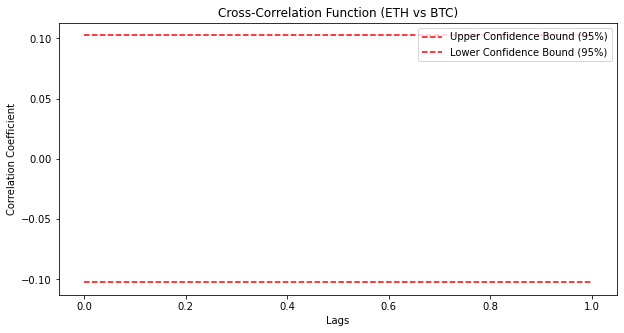

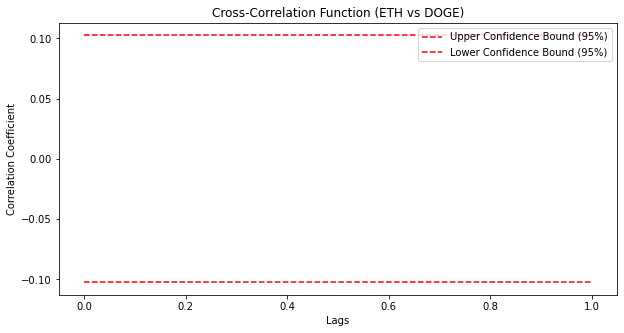

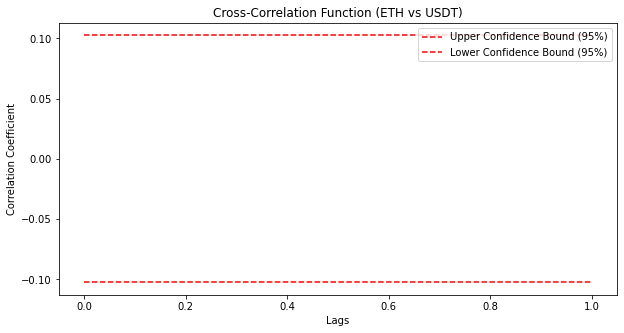

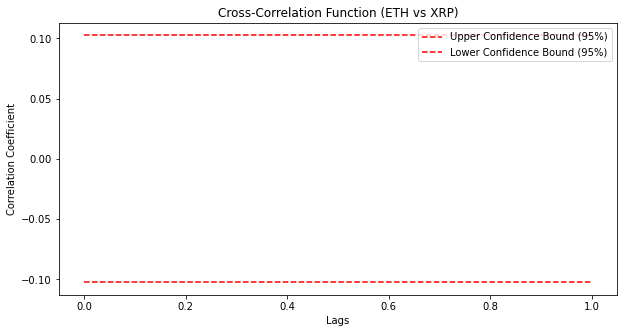

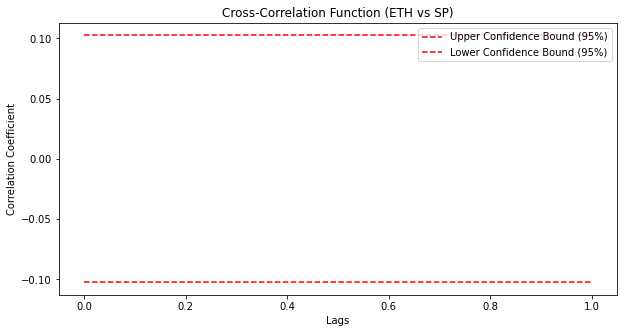

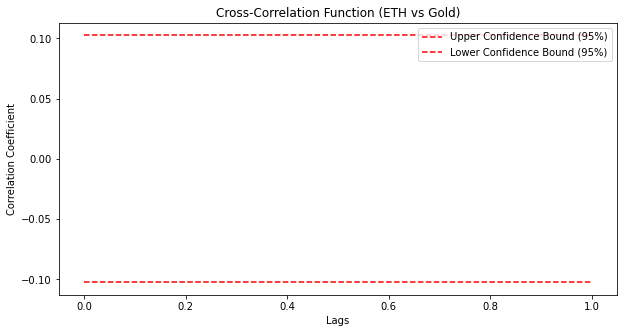

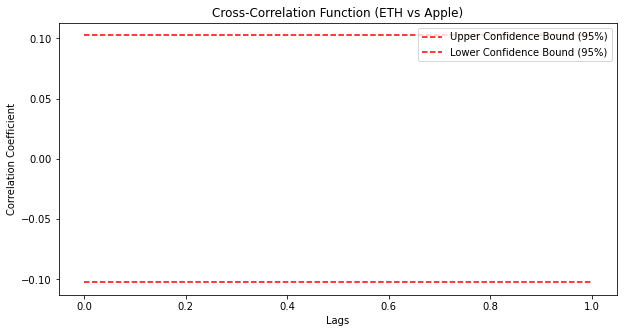

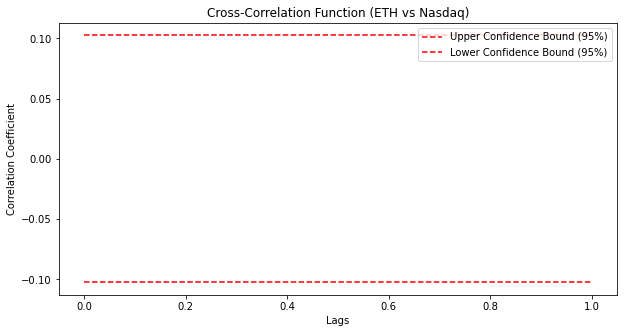

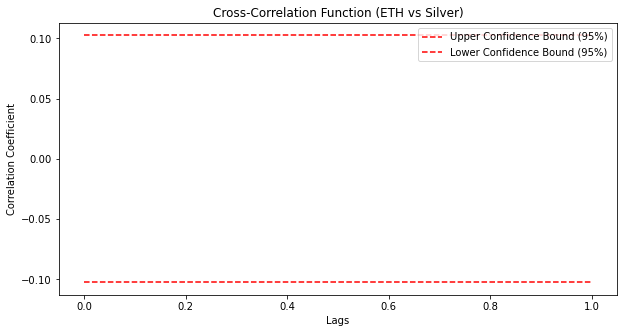

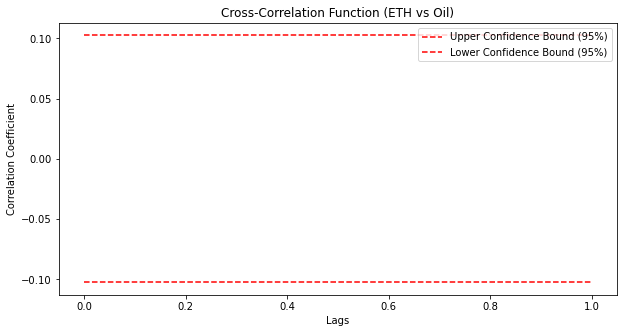

In [45]:
#Hypothesis 2:
"""
Null Hypothesis (H0): There is no discernible delay in correlation between the market values of Ethereum, other 
cryptocurrencies and other market indicators. 
Alternative Hypothesis (H1): A discernible delay exists in the correlation between the market values of 
Ethereum, other cryptocurrencie and other market indicators. 

Requires data to be stationary 

Goal is to dentify Significant Lags where the cross-correlation coefficients are significantly high
as these suggest a potential delay in the influence between Ethereum, other cryptocurrency and market indicators



"""
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import ccf

# Assuming 'df_clean_stationary' is your preprocessed DataFrame with stationary data
columns = ['Close_BTC', 'Close_DOGE', 'Close_USDT', 'Close_XRP', 'Close_SP','Close_Gold','Close_Apple',
          'Close_Nasdaq','Close_Silver','Close_Oil']

# Define the number of lags based on the frequency of your data
# For daily data, we might choose up to 30 lags. Adjust as needed for your dataset.
num_lags = 1

# Calculate the confidence interval for significance of the cross-correlations
# The usual significance level is chosen here as 95%
n = len(df_clean_stationary['Close_ETH'])
conf_interval = 1.96 / np.sqrt(n)  # 95% confidence interval

for column in columns:
    # Compute the cross-correlation function for a limited number of lags
    cross_corr = ccf(df_clean_stationary_extended['Close_ETH'], df_clean_stationary_extended[column])[:num_lags]

    # Plot the cross-correlation function with confidence intervals
    plt.figure(figsize=(10, 5))
    plt.stem(range(len(cross_corr)), cross_corr, use_line_collection=True, basefmt=" ")
    plt.hlines(conf_interval, xmin=0, xmax=num_lags, colors='r', linestyles='dashed', label='Upper Confidence Bound (95%)')
    plt.hlines(-conf_interval, xmin=0, xmax=num_lags, colors='r', linestyles='dashed', label='Lower Confidence Bound (95%)')
    plt.title(f'Cross-Correlation Function (ETH vs {column.replace("Close_", "")})')
    plt.xlabel('Lags')
    plt.ylabel('Correlation Coefficient')
    plt.legend()
    plt.show()

